# Read Data and Create Necessary Columns

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
data = pd.read_csv('../data/transactions_ds.csv', sep=';')
del data['price_ttc']

data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.tz_convert('Europe/Paris')

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute

data['total_spendings'] = data['quantity'] * data['price_ht']

data.head(10)

,item_id,quantity,price_ht,transaction_id,date,year,month,day,hour,minute,total_spendings
0,0,1.0,12.42,1,2018-03-08 14:10:59+01:00,2018,3,8,14,10,12.42
1,1,1.0,12.42,1,2018-03-08 14:10:59+01:00,2018,3,8,14,10,12.42
2,2,1.0,12.42,1,2018-03-08 14:10:59+01:00,2018,3,8,14,10,12.42
3,3,1.0,12.42,1,2018-03-08 14:10:59+01:00,2018,3,8,14,10,12.42
4,1,1.0,11.56,2,2018-03-08 14:12:07+01:00,2018,3,8,14,12,11.56
5,4,1.0,11.56,2,2018-03-08 14:12:07+01:00,2018,3,8,14,12,11.56
6,5,1.0,11.56,2,2018-03-08 14:12:07+01:00,2018,3,8,14,12,11.56
7,1,1.0,10.05,3,2018-03-08 14:12:18+01:00,2018,3,8,14,12,10.05
8,6,1.0,10.05,3,2018-03-08 14:12:18+01:00,2018,3,8,14,12,10.05
9,0,1.0,10.05,3,2018-03-08 14:12:18+01:00,2018,3,8,14,12,10.05


# Basic Statistics

In [9]:
data[['quantity', 'price_ht']].describe()

,quantity,price_ht
count,458730.000000,458730.000000
mean,1.474605,6.087067
std,32.118033,9.284162
min,0.008000,-3.320000
25%,1.000000,2.920000
50%,1.000000,4.640000
75%,1.000000,7.580000
max,14445.000000,1160.190000


<AxesSubplot: ylabel='Frequency'>

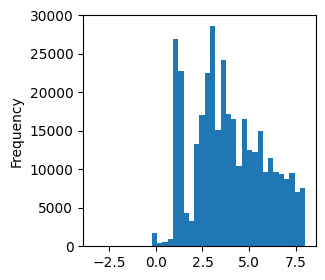

In [17]:
data[data['price_ht'] < 8].price_ht.plot(kind='hist', 
                                         bins=40,
                                         figsize=(3, 3))

<AxesSubplot: xlabel='month'>

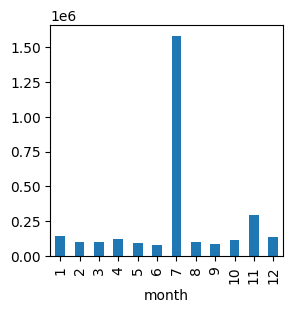

In [16]:
data[data['year'] == 2021].groupby(['month'])['total_spendings'].sum().plot(kind='bar', 
                                                                            figsize=(3, 3))

<AxesSubplot: xlabel='day'>

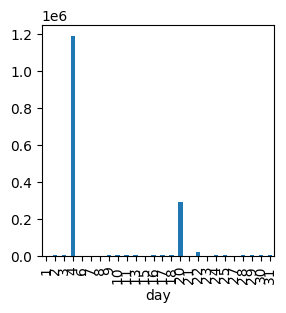

In [18]:
data[(data['year'] == 2021) & (data['month'] == 7)].groupby(['day'])['total_spendings'].sum().plot(kind='bar',
                                                                                                   figsize=(3, 3))